<a href="https://colab.research.google.com/github/isosafrasaurus/3D-1D/blob/main/3D1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
WD_PATH = "/content/drive/MyDrive/Research/3D-1D/"
VENV_PATH = WD_PATH + "/.venv"

In [ ]:
# @title install and import required libraries
%%capture
!pip3 install virtualenv

import os, re
if not os.path.exists(VENV_PATH):
  !virtualenv $VENV_PATH

import sys
sys.path.append(VENV_PATH + "/lib/python3.10/site-packages")

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

# block
try:
    import block
except ImportError:
    !git clone https://bitbucket.org/fenics-apps/cbc.block/src/master/
    !source $VENV_PATH/bin/activate && python3 -m pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone https://github.com/MiroK/fenics_ii
    process_directory("fenics_ii/")
    !source $VENV_PATH/bin/activate && python3 -m pip install fenics_ii/

# vtk
try:
    import vtk
except ImportError:
    !source $VENV_PATH/bin/activate && pip install vtk

# graphnics
try:
    import graphnics
except ImportError:
    !git clone https://github.com/IngeborgGjerde/graphnics
    !source $VENV_PATH/bin/activate && python3 -m pip install graphnics/

In [ ]:
# @title pv_1 modified over serena data mod
import json
import pandas as pd
from dolfin import *
from xii import *
import numpy as np
from graphnics import *
import matplotlib.pyplot as plt

# function to load JSON data into a DataFrame
def json_to_dataframe(file_path):
    with open(file_path) as f:
        data = json.load(f)
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    coords = [point['position'] for point in points]
    df = pd.DataFrame(coords, columns=['x', 'y', 'z'])
    df['radius'] = radius
    return df

# convert all JSON files into df and store them in an array
dataframes = []
for n in range(29):
    file_name = WD_PATH + '/data/pv_json1_mod/Centerline_' + str(n) + '.mrk.json'
    df = json_to_dataframe(file_name)
    dataframes.append(df)

G = FenicsGraph()
ind = 0
branch_points = {}

for n, df in enumerate(dataframes):
    # Get coords + radius at each point
    points = df[['x', 'y', 'z']].values.tolist()
    radius = df['radius'].tolist()
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # Check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0] == val:
            v1 = key
            break

    # Add coords and radius to nodes Fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]
    pos_v2 = points[1]
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    G.add_edge(v1, v2)

    for i in range(len(points) - 2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]
        pos_v2 = points[i + 2]
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)

    # Store last point as a branch point
    ind += len(points)
    branch_points.update({ind - n - 1: pos_v2})

# create 1D mesh
G.make_mesh()
mesh1d = G.mesh

# get positions of 1D mesh
pos = nx.get_node_attributes(G, "pos")
radii = nx.get_node_attributes(G, "radius")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis=0)

# recenter 1D coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

mesh3d = UnitCubeMesh(16, 16, 32)

# fit 3D mesh around 1D mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0) - np.min(node_coords, axis=0))  # graph length scales
c[:, :] *= [xl + 3, yl + 3, zl]  # Rescale lengths

# set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)
p_infty = Constant(2)  # Set the far-field pressure value
gamma = Constant(4)  # Set the gamma value

# set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# define function that returns lateral faces of 3D boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

def boundary_1d_0(x, on_boundary):
    return near(x[0], 0)

# Calculate the length of the 1D vessel
L = np.max(d[:, 0]) - np.min(d[:, 0])

def boundary_1d_L(x, on_boundary):
    return near(x[0], L)

# pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# create a radius function for the averaging surface
class RadiusFunction(UserExpression):
    def __init__(self, radii_map, pos_map, **kwargs):
        self.radii_map = radii_map
        self.pos_map = pos_map
        super().__init__(**kwargs)

    def eval(self, value, x):
        min_dist = float('inf')
        closest_radius = 0
        for node, position in self.pos_map.items():
            pos = np.array(position)
            dist = np.linalg.norm(x - pos)
            if dist < min_dist:
                min_dist = dist
                closest_radius = self.radii_map[node]
        value[0] = closest_radius

    def value_shape(self):
        return ()

radius_function = RadiusFunction(radii, pos, degree=2)
cylinder = Circle(radius=radius_function, degree=10)

Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

# Dirac measure
dxGamma = Measure("dx", domain=mesh1d)

# Create MeshFunctions for boundary conditions
boundary_markers_1d = MeshFunction("size_t", mesh1d, mesh1d.topology().dim()-1, 0)
AutoSubDomain(boundary_1d_0).mark(boundary_markers_1d, 1)
AutoSubDomain(boundary_1d_L).mark(boundary_markers_1d, 2)

# blocks
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

# right-hand side
L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

# Add Robin boundary terms (correct usage of trial and test functions)
a11 += gamma * u1 * v1 * ds(subdomain_data=boundary_markers_1d, subdomain_id=1)
a11 += gamma * u1 * v1 * ds(subdomain_data=boundary_markers_1d, subdomain_id=2)

L1 += gamma * p_infty * v1 * ds(subdomain_data=boundary_markers_1d, subdomain_id=1)
L1 += gamma * p_infty * v1 * ds(subdomain_data=boundary_markers_1d, subdomain_id=2)

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], []] # DirichletBC(V1, bc_1d, "on_boundary")

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
File(WD_PATH + 'plots/pv1_mod/pressure1d.pvd') << uh1d
File(WD_PATH + 'plots/pv1_mod/pressure3d.pvd') << uh3d

Averaging over 792 cells: 100%|██████████| 792/792 [00:10<00:00, 74.11it/s]
Level 25:FFC:  Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:  Compiling form ffc_form_81d6782954da2169a25021fbb93cc6145efa3407
  
INFO:FFC:  Compiler stage 1: Analyzing form(s)
INFO:FFC:  -----------------------------------
DEBUG:FFC:    Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:    
INFO:FFC:    Geometric dimension:                 3
    Number of cell subdomains:           0
    Number of exterior_facet subdomains: 3
    Rank:                                2
    Arguments:                           '(v_0, v_1)'
    Number of coefficients:              3
    Coefficients:                        '[f_260, f_261, f_263]'
    Unique elements:                     'CG1(?,?), R0(?

In [ ]:
import vtk
import pandas as pd
from vtk.util.numpy_support import vtk_to_numpy

# Function to read .vtk file and extract required information
def read_vtk_file(file_path):
    # Read the .vtk file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()

    # Extract the unstructured grid
    output = reader.GetOutput()

    # Extract point coordinates
    points = vtk_to_numpy(output.GetPoints().GetData())

    # Extract connectivity information
    connectivity = []
    for i in range(output.GetNumberOfCells()):
        cell = output.GetCell(i)
        connectivity.append([cell.GetPointId(j) for j in range(cell.GetNumberOfPoints())])

    # Extract data arrays
    damage = vtk_to_numpy(output.GetPointData().GetArray("Damage"))
    radius = vtk_to_numpy(output.GetPointData().GetArray("Radius"))

    # Create DataFrame
    df_points = pd.DataFrame(points, columns=['x', 'y', 'z'])
    df_points['Damage'] = damage
    df_points['Radius'] = radius

    # Create DataFrame for connectivity
    df_connectivity = pd.DataFrame(connectivity, columns=['point1', 'point2'])

    return df_points, df_connectivity

# Example usage
file_path = WD_PATH + 'data/vtk/sortedDomain.vtk'
df_points, df_connectivity = read_vtk_file(file_path)

In [ ]:
# Import necessary libraries
from dolfin import *
from xii import *
import numpy as np
from graphnics import *
import matplotlib.pyplot as plt

# Initialize the FenicsGraph
G = FenicsGraph()

# Add nodes to the graph from df_points
for index, row in df_points.iterrows():
    G.add_node(index, pos=(row['x'], row['y'], row['z']), radius=row['Radius'], damage=row['Damage'])

# Add edges to the graph from df_connectivity
for index, row in df_connectivity.iterrows():
    G.add_edge(row['point1'], row['point2'])

# Create 1D mesh
G.make_mesh()
mesh1d = G.mesh

# Get positions of 1D mesh
pos = nx.get_node_attributes(G, "pos")
radii = nx.get_node_attributes(G, "radius")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis=0)

# Recenter 1D coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# Create 3D mesh
mesh3d = UnitCubeMesh(16, 16, 32)

# Fit 3D mesh around 1D mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0) - np.min(node_coords, axis=0))  # graph length scales
c[:, :] *= [xl + 3, yl + 3, zl]  # Rescale lengths

# Set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# Set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# Define function that returns lateral faces of 3D boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

# Pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# Create a radius function for the averaging surface
class RadiusFunction(UserExpression):
    def __init__(self, radii_map, pos_map, **kwargs):
        self.radii_map = radii_map
        self.pos_map = pos_map
        super().__init__(**kwargs)

    def eval(self, value, x):
        min_dist = float('inf')
        closest_radius = 0
        for node, position in self.pos_map.items():
            pos = np.array(position)
            dist = np.linalg.norm(x - pos)
            if dist < min_dist:
                min_dist = dist
                closest_radius = self.radii_map[node]
        value[0] = closest_radius

    def value_shape(self):
        return ()

radius_function = RadiusFunction(radii, pos, degree=2)
cylinder = Circle(radius=radius_function, degree=10)

Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

# Dirac measure
dxGamma = Measure("dx", domain=mesh1d)

# Blocks
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

# Right-hand side
L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], [DirichletBC(V1, bc_1d, "on_boundary")]]

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
File(WD_PATH + 'plots/pv1_mod/pressure1d.pvd') << uh1d
File(WD_PATH + 'plots/pv1_mod/pressure3d.pvd') << uh3d

Averaging over 12326 cells: 100%|██████████| 12326/12326 [14:14<00:00, 14.43it/s]


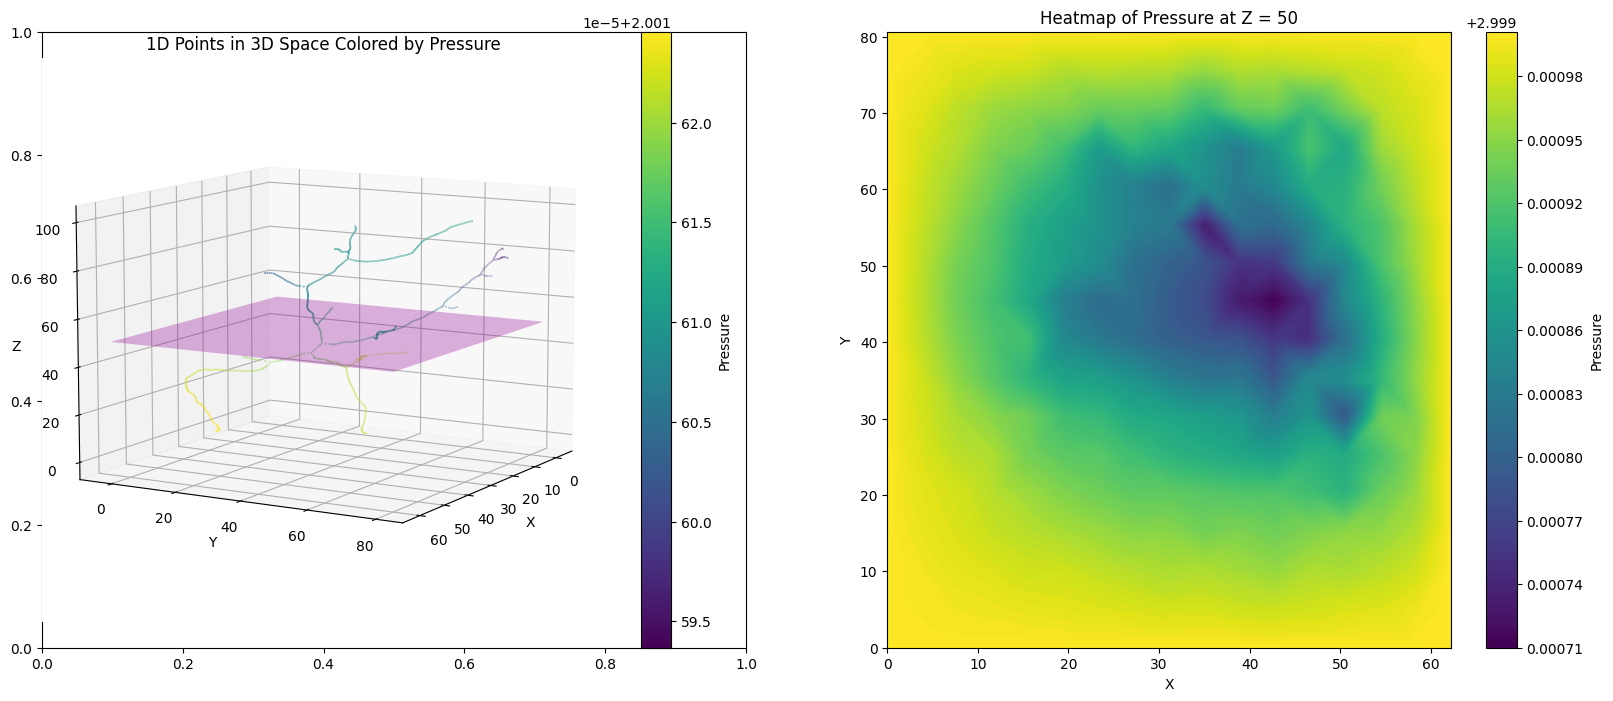

In [ ]:
#@title visualizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
from dolfin import *

# Extract the 1D node coordinates
node_coords = mesh1d.coordinates()

# Extract the pressure values at the 1D nodes
pressure_values = uh1d.compute_vertex_values(mesh1d)

z_level = 50

# Extract the 3D pressure function values
pressure_3d_values = uh3d.compute_vertex_values(mesh3d)
coords_3d = mesh3d.coordinates()

z_coords = coords_3d[:, 2]
mask = np.isclose(z_coords, z_level, atol=mesh3d.hmin())
filtered_coords = coords_3d[mask]
filtered_pressure = pressure_3d_values[mask]

# Create a grid for the heatmap
x = filtered_coords[:, 0]
y = filtered_coords[:, 1]
z = filtered_pressure
grid_size = 100
xi = np.linspace(x.min(), x.max(), grid_size)
yi = np.linspace(y.min(), y.max(), grid_size)
zi = scipy.interpolate.griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Setting up the 3D subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.view_init(elev=10, azim=30) # Change perspective
sc = ax1.scatter(node_coords[:, 0], node_coords[:, 1], node_coords[:, 2], c=pressure_values, cmap='viridis', s=0.1)
cbar = plt.colorbar(sc, ax=ax1)
cbar.set_label('Pressure')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('1D Points in 3D Space Colored by Pressure')

# Insert a 2D plane at Z = z_level
x_range = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], num=10)
y_range = np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], num=10)
x_plane, y_plane = np.meshgrid(x_range, y_range)
z_plane = np.full(x_plane.shape, z_level)
ax1.plot_surface(x_plane, y_plane, z_plane, color='m', alpha=0.3)

# Setting up the 2D heatmap subplot
cf = ax2.contourf(xi, yi, zi, levels=100, cmap='viridis')
cbar = plt.colorbar(cf, ax=ax2)
cbar.set_label('Pressure')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title(f'Heatmap of Pressure at Z = {z_level}')

plt.show()

In [ ]:
# @title pv_1 modified using .vtk conversion
import pandas as pd
from dolfin import *
from xii import *
import numpy as np
from graphnics import *
import matplotlib.pyplot as plt

# Initialize the FenicsGraph
G = FenicsGraph()
ind = 0
branch_points = {}

# Read DataFrames instead of JSON files
for n, df in enumerate(centerline_dfs):
    # Get coords + radius at each point
    points = df[['x', 'y', 'z']].values.tolist()
    radius = df['radius'].tolist()
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # Check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0] == val:
            v1 = key
            break

    # Add coords and radius to nodes Fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]
    pos_v2 = points[1]
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    G.add_edge(v1, v2)

    for i in range(len(points) - 2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]
        pos_v2 = points[i + 2]
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)

    # Store last point as a branch point
    ind += len(points)
    branch_points.update({ind - n - 1: pos_v2})

# Create 1D mesh
G.make_mesh()
mesh1d = G.mesh

# Get positions of 1D mesh
pos = nx.get_node_attributes(G, "pos")
radii = nx.get_node_attributes(G, "radius")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis=0)

# Recenter 1D coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# Create 3D mesh
mesh3d = UnitCubeMesh(16, 16, 32)

# Fit 3D mesh around 1D mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0) - np.min(node_coords, axis=0))  # graph length scales
c[:, :] *= [xl + 3, yl + 3, zl]  # Rescale lengths

# Set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# Set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# Define function that returns lateral faces of 3D boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

# Pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# Create a radius function for the averaging surface
class RadiusFunction(UserExpression):
    def __init__(self, radii_map, pos_map, **kwargs):
        self.radii_map = radii_map
        self.pos_map = pos_map
        super().__init__(**kwargs)

    def eval(self, value, x):
        min_dist = float('inf')
        closest_radius = 0
        for node, position in self.pos_map.items():
            pos = np.array(position)
            dist = np.linalg.norm(x - pos)
            if dist < min_dist:
                min_dist = dist
                closest_radius = self.radii_map[node]
        value[0] = closest_radius

    def value_shape(self):
        return ()

radius_function = RadiusFunction(radii, pos, degree=2)
cylinder = Circle(radius=radius_function, degree=10)

Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

# Dirac measure
dxGamma = Measure("dx", domain=mesh1d)

# Blocks
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

# Right-hand side
L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], []] #DirichletBC(V1, bc_1d, "on_boundary")

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
uh3d.rename("Pressure_3D", "label_3D")
uh1d.rename("Pressure_1D", "label_1D")
File(WD_PATH + 'plots/pv1_mod_2/pressure1d.pvd') << uh1d
File(WD_PATH + 'plots/pv1_mod_2/pressure3d.pvd') << uh3d

Averaging over 4834 cells: 100%|██████████| 4834/4834 [02:25<00:00, 33.33it/s]


In [ ]:
# @title pv_1 modified over serena data
import json
import pandas as pd
from dolfin import *
from xii import *
import numpy as np
from graphnics import *
import matplotlib.pyplot as plt

# function to load JSON data into a DataFrame
def json_to_dataframe(file_path):
    with open(file_path) as f:
        data = json.load(f)
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    coords = [point['position'] for point in points]
    df = pd.DataFrame(coords, columns=['x', 'y', 'z'])
    df['radius'] = radius
    return df

# convert all JSON files into df and store them in an array
dataframes = []
for n in range(29):
    file_name = WD_PATH + '/data/pv_json1_mod/Centerline_' + str(n) + '.mrk.json'
    df = json_to_dataframe(file_name)
    dataframes.append(df)

G = FenicsGraph()
ind = 0
branch_points = {}

for n, df in enumerate(dataframes):
    # Get coords + radius at each point
    points = df[['x', 'y', 'z']].values.tolist()
    radius = df['radius'].tolist()
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # Check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0] == val:
            v1 = key
            break

    # Add coords and radius to nodes Fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]
    pos_v2 = points[1]
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    G.add_edge(v1, v2)

    for i in range(len(points) - 2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]
        pos_v2 = points[i + 2]
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)

    # Store last point as a branch point
    ind += len(points)
    branch_points.update({ind - n - 1: pos_v2})

# create 1D mesh
G.make_mesh()
mesh1d = G.mesh

# get positions of 1D mesh
pos = nx.get_node_attributes(G, "pos")
radii = nx.get_node_attributes(G, "radius")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis=0)

# recenter 1D coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

mesh3d = UnitCubeMesh(16, 16, 32)

# fit 3D mesh around 1D mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0) - np.min(node_coords, axis=0))  # graph length scales
c[:, :] *= [xl + 3, yl + 3, zl]  # Rescale lengths

# set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# define function that returns lateral faces of 3D boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

# pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# create a radius function for the averaging surface
class RadiusFunction(UserExpression):
    def __init__(self, radii_map, pos_map, **kwargs):
        self.radii_map = radii_map
        self.pos_map = pos_map
        super().__init__(**kwargs)

    def eval(self, value, x):
        min_dist = float('inf')
        closest_radius = 0
        for node, position in self.pos_map.items():
            pos = np.array(position)
            dist = np.linalg.norm(x - pos)
            if dist < min_dist:
                min_dist = dist
                closest_radius = self.radii_map[node]
        value[0] = closest_radius

    def value_shape(self):
        return ()

radius_function = RadiusFunction(radii, pos, degree=2)
cylinder = Circle(radius=radius_function, degree=10)

Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

# Dirac measure
dxGamma = Measure("dx", domain=mesh1d)

# blocks
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

# right-hand side
L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], [DirichletBC(V1, bc_1d, "on_boundary")]]

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
File(WD_PATH + 'plots/pv1_mod/pressure1d.pvd') << uh1d
File(WD_PATH + 'plots/pv1_mod/pressure3d.pvd') << uh3d

In [ ]:
# @title .vtk import test
import vtk

reader = vtk.vtkPolyDataReader()
reader.SetFileName(WD_PATH + 'data/vtk/sortedDomain.vtk')
reader.Update()

polydata = reader.GetOutput()
cells = polydata.GetLines()  # or GetPolys() for general cells

for cellId in range(cells.GetNumberOfCells()):
    cell = vtk.vtkIdList()
    cells.GetCell(cellId, cell)
    print("Cell", cellId, ":", [cell.GetId(i) for i in range(cell.GetNumberOfIds())])

In [ ]:
# @title branch partition test
def partition_into_branches(graph, start):
    def dfs(node, visited):
        stack = [(node, [node])]
        branches = []

        while stack:
            current, path = stack.pop()
            visited.add(current)

            # Check if the current node is a terminal node (no unvisited neighbors)
            neighbors = [n for n in graph[current] if n not in visited]
            if not neighbors:  # Terminal node
                if len(path) > 1:
                    branches.append(path)
            else:
                for neighbor in neighbors:
                    stack.append((neighbor, path + [neighbor]))

        return branches

    visited = set()
    all_branches = []

    # Start the partition from the initial start node
    all_branches.extend(dfs(start, visited))

    # Check for any unvisited nodes and use them as new branch points
    for node in graph:
        if node not in visited:
            all_branches.extend(dfs(node, visited))

    return all_branches

# Example usage
graph = {
    0: [1, 2],
    1: [0, 3, 4],
    2: [0, 5],
    3: [1],
    4: [1],
    5: [2]
}

start_node = 1
branches = partition_into_branches(graph, start_node)
for i, branch in enumerate(branches):
    print(f"Branch {i+1}: {branch}")


In [ ]:
# @title pv_1 modified old
import json
from dolfin import *
from xii import *
import numpy as np
from graphnics import *

G = FenicsGraph()
ind = 0
branch_points = {}

for n in range(1):
    file_name = WD_PATH+'/data/pv_json1_mod/Centerline_'+str(n)+'.mrk.json'
    f = open(file_name)
    data = json.load(f)
    f.close()

    # get coords + radius at each point
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0]['position'] == val:
            v1 = key
            break

    # add coords and radius to nodes fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]['position']
    pos_v2 = points[1]['position']
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    # add edge to fenics graph
    G.add_edge(v1, v2)

    for i in range(len(points)-2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]['position']
        pos_v2 = points[i + 2]['position']
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)


    # store last point as a branch point
    ind += len(points)
    branch_points.update({ind-n-1: pos_v2})


# create 1d mesh
G.make_mesh()
mesh1d = G.mesh

# get positions of 1d mesh
pos = nx.get_node_attributes(G, "pos")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis = 0)

# recenter 1d coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# create 3d mesh
mesh3d = UnitCubeMesh(16, 16, 32)

# fit 3d mesh around 1d mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0)-np.min(node_coords, axis=0)) # graph length scales
c[:,:] *= [xl+3, yl+3, zl] #rescale lengths

# set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# define function that returns lateral faces of 3d boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

from scipy.interpolate import interp1d
import numpy as np

# Assuming pos and radius arrays are created from JSON data
# pos = np.array([G.nodes[v]['pos'] for v in G.nodes])
radii = np.array([G.nodes[v]['radius'] for v in G.nodes])

# Interpolate radius function
def resample_array(x, num_points):
    x_new = np.linspace(np.min(x), np.max(x), num=num_points)
    f = interp1d(np.arange(len(x)), x, kind='linear')
    return f(np.linspace(0, len(x) - 1, num=num_points))

def radius_function(x):
    # Determine which array to resample
    if len(c[:, 2]) != len(radii):
        if len(c[:, 2]) > len(radii):
            new_radii = resample_array(radii, len(c[:, 2]))
            x_values = c[:, 2]
        else:
            x_values = resample_array(c[:, 2], len(radii))
            new_radii = radii
    else:
        x_values = c[:, 2]
        new_radii = radii

    interp_func = interp1d(x_values, new_radii, kind='linear', fill_value='extrapolate')

    # Use x[2] as the input to the interpolation function
    return interp_func(x[2])

# Averaging cylinder is defined by mapping points on the centerline to radii
cylinder = Circle(radius=radius_function, degree=10)

# Pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# Define varying radius cylinder for averaging
Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

# Define measures
dxGamma = Measure("dx", domain=mesh1d)

# Define bilinear and linear forms
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], [DirichletBC(V1, bc_1d, "on_boundary")]]

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
File(WD_PATH + 'plots/pv1mod/pressure1d.pvd') << uh1d
File(WD_PATH + 'plots/pv1mod/pressure3d.pvd') << uh3d

In [ ]:
# @title pv_1.py
import json
from dolfin import *
from xii import *
import numpy as np
from graphnics import *
import matplotlib as plt

G = FenicsGraph()
ind = 0
branch_points = {}

for n in range(1):
    file_name = WD_PATH+'/data/pv_json1/Centerline_'+str(n)+'.mrk.json'
    f = open(file_name)
    data = json.load(f)
    f.close()

    # get coords + radius at each point
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0]['position'] == val:
            v1 = key
            break

    # add coords and radius to nodes fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]['position']
    pos_v2 = points[1]['position']
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    # add edge to fenics graph
    G.add_edge(v1, v2)

    for i in range(len(points)-2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]['position']
        pos_v2 = points[i + 2]['position']
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)


    # store last point as a branch point
    ind += len(points)
    branch_points.update({ind-n-1: pos_v2})


# create 1d mesh
G.make_mesh()
mesh1d = G.mesh

# get positions of 1d mesh
pos = nx.get_node_attributes(G, "pos")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis = 0)

# recenter 1d coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# create 3d mesh
mesh3d = UnitCubeMesh(16, 16, 32)

# fit 3d mesh around 1d mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0)-np.min(node_coords, axis=0)) # graph length scales

c[:,:] *= [xl+3, yl+3, zl] #rescale lengths

# set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# define function that returns lateral faces of 3d boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

# Pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# Averaging surface
cylinder = Circle(radius=1.19, degree=10)

Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

#dirac measure
dxGamma = Measure("dx", domain=mesh1d)

# blocks
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

# right-hand side
L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], [DirichletBC(V1, bc_1d, "on_boundary")]]

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
plt.figure()
plot(uh3d)
# File(WD_PATH + 'plots/pv1/pressure1d.pvd') << uh1d
# File(WD_PATH + 'plots/pv1/pressure3d.pvd') << uh3d

In [ ]:
# @title pv_2.py
import json
from dolfin import *
from xii import *
import numpy as np
from graphnics import *

G = FenicsGraph()
ind = 0
branch_points = {}

for n in range(20):
    file_name = WD_PATH+'/data/pv_json2/Centerline_'+str(n)+'.mrk.json'
    f = open(file_name)
    data = json.load(f)
    f.close()

    # get coords + radius at each point
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0]['position'] == val:
            v1 = key
            break

    # add coords and radius to nodes fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]['position']
    pos_v2 = points[1]['position']
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    # add edge to fenics graph
    G.add_edge(v1, v2)

    for i in range(len(points)-2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]['position']
        pos_v2 = points[i + 2]['position']
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)


    # store last point as a branch point
    ind += len(points)
    branch_points.update({ind-n-1: pos_v2})


# create 1d mesh
G.make_mesh()
mesh1d = G.mesh

# get positions of 1d mesh
pos = nx.get_node_attributes(G, "pos")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis = 0)

# recenter 1d coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# create 3d mesh
mesh3d = UnitCubeMesh(16, 16, 32)

# fit 3d mesh around 1d mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0)-np.min(node_coords, axis=0)) # graph length scales

c[:,:] *= [xl+3, yl+3, zl] #rescale lengths


# set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# define function that returns lateral faces of 3d boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

# Pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# Averaging surface
cylinder = Circle(radius=1.19, degree=10)

Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

#dirac measure
dxGamma = Measure("dx", domain=mesh1d)

# blocks
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

# right-hand side
L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], [DirichletBC(V1, bc_1d, "on_boundary")]]

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
File('plots/pv2/pressure1d.pvd') << uh1d
File('plots/pv2/pressure3d.pvd') << uh3d